In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import time

def get_average_income(income_text):
    """
    文字列から年収の平均値を数値として返すサンプル関数。
    例：
      「600万円」 → 600.0
      「600万円～1300万円」 → 950.0
      「800万円～」 → 800.0 (上限なしの場合)
    """

    range_pattern = r'(\d+)\s*万円\s*[-～~]\s*(\d+)\s*万円'
    m_range = re.search(range_pattern, income_text)
    if m_range:
        low = int(m_range.group(1))
        high = int(m_range.group(2))
        return (low + high) / 2.0

    single_pattern = r'(\d+)\s*万円'
    m_single = re.search(single_pattern, income_text)
    if m_single:
        return float(m_single.group(1))

    return None

def parse_job_card(job_card):
    """
    job_card: BeautifulSoupオブジェクトで取得した1件分の<li>要素
    戻り値: dict 形式の求人情報
    """

    company_tag = job_card.select_one('p.font-size16.text-ellipsis.mb05.mt10')
    company_name = company_tag.get_text(strip=True) if company_tag else ""

    income_tag = job_card.select_one('p.font-size16.text__bold.text-ellipsis.mb10')
    income_text = income_tag.get_text(strip=True) if income_tag else ""
    average_income = get_average_income(income_text)

    title_tag = job_card.select_one('p.text__bold.font-size18.text-ellipsis')
    title = title_tag.get_text(strip=True) if title_tag else ""

    list_items = job_card.select('ul.list-tag.align-items-center li')
    tags = [li.get_text(strip=True) for li in list_items]

    is_inexperienced_ok = any("未経験歓迎" in t for t in tags)

    return {
        'title': title,
        'company_name': company_name,
        'income_text': income_text,
        'average_income': average_income,
        'tags': tags,
        'is_inexperienced_ok': is_inexperienced_ok,
    }

def main():
    all_jobs_data = []  

    for page_num in range(1, 1568):
        url = f"https://scouting.mynavi.jp/job-list/?page={page_num}"
        resp = requests.get(url)
        
        if not resp.ok:
            print(f"Page {page_num} HTTP Error: {resp.status_code}")
            continue

        soup = BeautifulSoup(resp.text, 'html.parser')
    
        job_cards = soup.select('li.pt15.mt15.bg_color.position-relative')
        if not job_cards:
            print(f"Page {page_num}: No job cards found.")
            continue

        page_jobs_data = [parse_job_card(card) for card in job_cards]
        all_jobs_data.extend(page_jobs_data)

        print(f"Page {page_num} done. Jobs found: {len(page_jobs_data)}")

        time.sleep(1)

    inexperienced_jobs = [j for j in all_jobs_data if j['is_inexperienced_ok']]
    experienced_jobs = [j for j in all_jobs_data if not j['is_inexperienced_ok']]

    def calc_mean_income(job_list):
        incomes = [j['average_income'] for j in job_list if j['average_income'] is not None]
        return sum(incomes)/len(incomes) if incomes else None

    avg_inexperienced = calc_mean_income(inexperienced_jobs)
    avg_experienced   = calc_mean_income(experienced_jobs)

    print("========================================")
    print(f"Total pages crawled       : 1 ～ 1567")
    print(f"Total job cards collected : {len(all_jobs_data)}")
    print(f"未経験歓迎求人            : {len(inexperienced_jobs)} 件")
    print(f"それ以外の求人            : {len(experienced_jobs)} 件\n")

    print(f"■未経験歓迎求人の平均年収: {avg_inexperienced if avg_inexperienced else 'データなし'}")
    print(f"■その他求人の平均年収    : {avg_experienced   if avg_experienced   else 'データなし'}")

if __name__ == "__main__":
    main()

Page 1 done. Jobs found: 50
Page 2 done. Jobs found: 50
Page 3 done. Jobs found: 50
Page 4 done. Jobs found: 50
Page 5 done. Jobs found: 50
Page 6 done. Jobs found: 50
Page 7 done. Jobs found: 50
Page 8 done. Jobs found: 50
Page 9 done. Jobs found: 50
Page 10 done. Jobs found: 50
Page 11 done. Jobs found: 50
Page 12 done. Jobs found: 50
Page 13 done. Jobs found: 50
Page 14 done. Jobs found: 50
Page 15 done. Jobs found: 50
Page 16 done. Jobs found: 50
Page 17 done. Jobs found: 50
Page 18 done. Jobs found: 50
Page 19 done. Jobs found: 50
Page 20 done. Jobs found: 50
Page 21 done. Jobs found: 50
Page 22 done. Jobs found: 50
Page 23 done. Jobs found: 50
Page 24 done. Jobs found: 50
Page 25 done. Jobs found: 50
Page 26 done. Jobs found: 50
Page 27 done. Jobs found: 50
Page 28 done. Jobs found: 50
Page 29 done. Jobs found: 50
Page 30 done. Jobs found: 50
Page 31 done. Jobs found: 50
Page 32 done. Jobs found: 50
Page 33 done. Jobs found: 50
Page 34 done. Jobs found: 50
Page 35 done. Jobs foun

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import time
import sqlite3
import os

DB_NAME = "jobs.db"

def get_average_income(income_text):
    """
    文字列から年収の平均値を数値として返すサンプル関数。
    例： 
      「600万円」 → 600.0
      「600万円～1300万円」 → 950.0
      「800万円～」 → 800.0 (上限なしの場合)
    """
   
    range_pattern = r'(\d+)\s*万円\s*[-～~]\s*(\d+)\s*万円'
    m_range = re.search(range_pattern, income_text)
    if m_range:
        low = int(m_range.group(1))
        high = int(m_range.group(2))
        return (low + high) / 2.0

    single_pattern = r'(\d+)\s*万円'
    m_single = re.search(single_pattern, income_text)
    if m_single:
        return float(m_single.group(1))

    return None

def parse_job_card(job_card):
    """
    job_card: BeautifulSoupオブジェクトで取得した1件分の<li>要素
    戻り値: dict 形式の求人情報
    """
   
    company_tag = job_card.select_one('p.font-size16.text-ellipsis.mb05.mt10')
    company_name = company_tag.get_text(strip=True) if company_tag else ""

    income_tag = job_card.select_one('p.font-size16.text__bold.text-ellipsis.mb10')
    income_text = income_tag.get_text(strip=True) if income_tag else ""
    average_income = get_average_income(income_text)

    title_tag = job_card.select_one('p.text__bold.font-size18.text-ellipsis')
    title = title_tag.get_text(strip=True) if title_tag else ""

    list_items = job_card.select('ul.list-tag.align-items-center li')
    tags = [li.get_text(strip=True) for li in list_items]

    is_inexperienced_ok = any("未経験歓迎" in t for t in tags)

    return {
        'title': title,
        'company_name': company_name,
        'income_text': income_text,
        'average_income': average_income,
        'tags': ", ".join(tags), 
        'is_inexperienced_ok': is_inexperienced_ok,
    }

def init_db():
    """
    SQLiteデータベースに jobs テーブルを作成（既にあれば作らない）。
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    
    create_table_sql = """
    CREATE TABLE IF NOT EXISTS jobs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        title TEXT,
        company_name TEXT,
        income_text TEXT,
        average_income REAL,
        tags TEXT,
        is_inexperienced_ok INTEGER
    );
    """
    cur.execute(create_table_sql)
    conn.commit()
    conn.close()

def insert_job_data(job_data_list):
    """
    スクレイピングで得た求人情報のリストをDBにINSERT
    job_data_list: [{'title':..., 'company_name':..., 'income_text':..., ...}, ...]
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()

    insert_sql = """
    INSERT INTO jobs
    (title, company_name, income_text, average_income, tags, is_inexperienced_ok)
    VALUES (?, ?, ?, ?, ?, ?)
    """

    records = []
    for j in job_data_list:
        records.append((
            j['title'],
            j['company_name'],
            j['income_text'],
            j['average_income'] if j['average_income'] is not None else None,
            j['tags'],
            1 if j['is_inexperienced_ok'] else 0
        ))
    cur.executemany(insert_sql, records)

    conn.commit()
    conn.close()

def count_total_jobs():
    """
    jobs テーブルに登録されている求人件数を返す
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM jobs")
    total = cur.fetchone()[0]
    conn.close()
    return total

def count_inexperienced_jobs():
    """
    未経験歓迎(is_inexperienced_ok = 1)の求人件数を返す
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM jobs WHERE is_inexperienced_ok = 1")
    count = cur.fetchone()[0]
    conn.close()
    return count

def count_experienced_jobs():
    """
    未経験歓迎以外(is_inexperienced_ok = 0)の求人件数を返す
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM jobs WHERE is_inexperienced_ok = 0")
    count = cur.fetchone()[0]
    conn.close()
    return count

def get_avg_income_inexperienced():
    """
    未経験歓迎(is_inexperienced_ok=1)の平均年収を返す
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    cur.execute("SELECT AVG(average_income) FROM jobs WHERE is_inexperienced_ok=1")
    avg_inexperienced = cur.fetchone()[0]  # None or float
    conn.close()
    return avg_inexperienced

def get_avg_income_experienced():
    """
    未経験歓迎以外(is_inexperienced_ok=0)の平均年収を返す
    """
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    cur.execute("SELECT AVG(average_income) FROM jobs WHERE is_inexperienced_ok=0")
    avg_experienced = cur.fetchone()[0]  
    conn.close()
    return avg_experienced

def main():
    
    if os.path.exists(DB_NAME):
        os.remove(DB_NAME)

   
    init_db()

    all_jobs_data = [] 

    for page_num in range(1, 1568):
        url = f"https://scouting.mynavi.jp/job-list/?page={page_num}"
        resp = requests.get(url)
        
        if not resp.ok:
            print(f"Page {page_num} HTTP Error: {resp.status_code}")
            continue

        soup = BeautifulSoup(resp.text, 'html.parser')
        job_cards = soup.select('li.pt15.mt15.bg_color.position-relative')
        if not job_cards:
            print(f"Page {page_num}: No job cards found.")
            continue

        page_jobs_data = [parse_job_card(card) for card in job_cards]
        all_jobs_data.extend(page_jobs_data)

        print(f"Page {page_num} done. Jobs found: {len(page_jobs_data)}")
        
        time.sleep(1)

    insert_job_data(all_jobs_data)

    total_count = count_total_jobs()
   
    inexperienced_count = count_inexperienced_jobs()
   
    experienced_count = count_experienced_jobs()

    avg_inexperienced = get_avg_income_inexperienced()
    avg_experienced = get_avg_income_experienced()

    avg_inexperienced_str = f"{avg_inexperienced:.2f}" if avg_inexperienced else "データなし"
    avg_experienced_str   = f"{avg_experienced:.2f}"   if avg_experienced   else "データなし"

    print("========================================")
    print(f"Total pages crawled       : 1 ～ 1567")
    print(f"Total job cards collected : {total_count}")
    print(f"未経験歓迎求人            : {inexperienced_count} 件")
    print(f"その他の求人              : {experienced_count} 件\n")

    print(f"■未経験歓迎求人の平均年収: {avg_inexperienced_str}")
    print(f"■その他求人の平均年収    : {avg_experienced_str}")

if __name__ == "__main__":
    main()

Page 1 done. Jobs found: 50
Page 2 done. Jobs found: 50
Page 3 done. Jobs found: 50
Page 4 done. Jobs found: 50
Page 5 done. Jobs found: 50
Page 6 done. Jobs found: 50
Page 7 done. Jobs found: 50
Page 8 done. Jobs found: 50
Page 9 done. Jobs found: 50
Page 10 done. Jobs found: 50
Page 11 done. Jobs found: 50
Page 12 done. Jobs found: 50
Page 13 done. Jobs found: 50
Page 14 done. Jobs found: 50
Page 15 done. Jobs found: 50
Page 16 done. Jobs found: 50
Page 17 done. Jobs found: 50
Page 18 done. Jobs found: 50
Page 19 done. Jobs found: 50
Page 20 done. Jobs found: 50
Page 21 done. Jobs found: 50
Page 22 done. Jobs found: 50
Page 23 done. Jobs found: 50
Page 24 done. Jobs found: 50
Page 25 done. Jobs found: 50
Page 26 done. Jobs found: 50
Page 27 done. Jobs found: 50
Page 28 done. Jobs found: 50
Page 29 done. Jobs found: 50
Page 30 done. Jobs found: 50
Page 31 done. Jobs found: 50
Page 32 done. Jobs found: 50
Page 33 done. Jobs found: 50
Page 34 done. Jobs found: 50
Page 35 done. Jobs foun

In [42]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # Seabornのスタイルを適用

# DBから読み込み
conn = sqlite3.connect("jobs.db")
df_jobs = pd.read_sql_query("SELECT * FROM jobs", conn)
conn.close()

# 「1:未経験歓迎, 0:経験者のみ」→ ラベルに変換
df_jobs["inexperienced_label"] = df_jobs["is_inexperienced_ok"].map({
    1: "未経験歓迎",
    0: "経験者のみ"
})

# 年収カラムがNaNの行は可視化時に除外するためフィルタリングしておく
df_filtered = df_jobs.dropna(subset=["average_income"])

print("Data loaded. Row count:", len(df_jobs))
df_jobs.head()

Data loaded. Row count: 78350


,id,title,company_name,income_text,average_income,tags,is_inexperienced_ok,inexperienced_label
0,1,【CS_CS】カスタマーサクセスグループ長候補,株式会社SHIFT,900万円～1300万円,1100.0,"上場企業, 学歴不問",0,経験者のみ
1,2,【リモート歓迎・転勤なし】プロジェクトマネージャー／プロジェクトリーダー【モビリティサービス...,株式会社SHIFT,600万円～,600.0,"上場企業, 学歴不問",0,経験者のみ
2,3,【名古屋】女性活躍！フルリモート相談可_ワークライフバランスと昇給共に叶える／プロジェクトマ...,株式会社SHIFT,600万円～,600.0,"上場企業, 学歴不問",0,経験者のみ
3,4,【名古屋】※リモート歓迎・転勤なし※プロジェクトマネージャー／プロジェクトリーダー,株式会社SHIFT,600万円～,600.0,"上場企業, 学歴不問",0,経験者のみ
4,5,【QAリーダー】エンターテインメント業界_大阪／ヒットを生むための魅力的品質の最大化,株式会社SHIFT,600万円～,600.0,"上場企業, 学歴不問",0,経験者のみ


In [ ]:
import sqlite3

DB_NAME = "jobs.db"

def count_jobs_with_gakureki_fumon():
    """
    SQLiteテーブル 'jobs' の 'tags' 列に '学歴不問' を含む求人をカウント
    """
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    sql = """
    SELECT COUNT(*) 
    FROM jobs
    WHERE tags LIKE '%学歴不問%'
    """
    cursor.execute(sql)
    count_gakureki_fumon = cursor.fetchone()[0] 
    conn.close()

    return count_gakureki_fumon

if __name__ == "__main__":
    result = count_jobs_with_gakureki_fumon()
    print("学歴不問タグを含む求人件数:", result)

学歴不問タグを含む求人件数: 75216


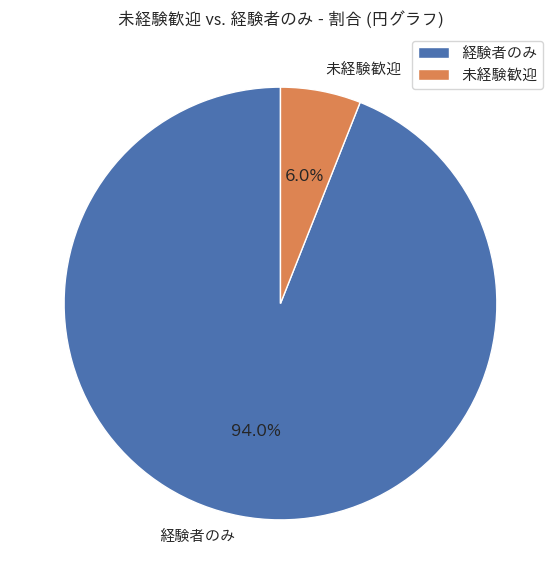

In [21]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# (必要に応じて) 日本語の文字化け回避のためのライブラリ
# pip install japanize-matplotlib を行ったうえでコメントアウトを外してください
#import japanize_matplotlib

def main():
    # 1) jobs.dbのjobsテーブルからデータを読み込み
    conn = sqlite3.connect("jobs.db")
    df_jobs = pd.read_sql_query("SELECT * FROM jobs", conn)
    conn.close()

    # 2) is_inexperienced_ok カラム(数値)を文字ラベルにマッピング
    #    1 → "未経験歓迎", 0 → "経験者のみ"
    df_jobs["inexperienced_label"] = df_jobs["is_inexperienced_ok"].map({
        1: "未経験歓迎",
        0: "経験者のみ"
    })

    # 3) 円グラフ用に集計して描画
    count_series = df_jobs["inexperienced_label"].value_counts()

    plt.figure(figsize=(6,6))
    count_series.plot(kind="pie", autopct="%1.1f%%", startangle=90)
    plt.title("未経験歓迎 vs. 経験者のみ - 割合 (円グラフ)")
    plt.ylabel("")  # 不要なy軸ラベルを消す
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

/var/folders/rf/gw7rg5j57fbc_wwwdyr56jh40000gn/T/ipykernel_99445/2178399632.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="Set2")


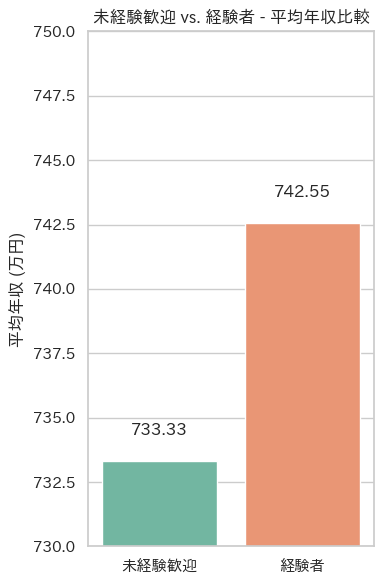

In [41]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # 1) データベースからデータを取得
    conn = sqlite3.connect("jobs.db")
    df_jobs = pd.read_sql_query("SELECT * FROM jobs", conn)
    conn.close()

    # 2) 前処理 (average_income が有効値である行のみを対象)
    df_filtered = df_jobs[
        (df_jobs["average_income"].notnull()) &
        (df_jobs["average_income"] > 0)
    ].copy()

    # 「未経験歓迎」を判定
    df_filtered["is_inexperienced_ok"] = df_filtered["is_inexperienced_ok"].fillna(0)

    # 3) 平均年収の計算
    inexperienced_mean = df_filtered[df_filtered["is_inexperienced_ok"] == 1]["average_income"].mean()
    others_mean = df_filtered[df_filtered["is_inexperienced_ok"] != 1]["average_income"].mean()

    labels = ["未経験歓迎", "経験者"]
    values = [inexperienced_mean, others_mean]

    # 4) グラフ描画
    plt.figure(figsize=(4, 6))
    sns.barplot(x=labels, y=values, palette="Set2")

    # 値を上に表示
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.2f}", ha="center", fontweight='bold')

    # 5) Y 軸設定（下限をあえて高めに設定して差を大きく見せる）
    #    例: 730～750 を表示する
    plt.ylim(730, 750)

    plt.title("未経験歓迎 vs. 経験者 - 平均年収比較")
    plt.xlabel("")
    plt.ylabel("平均年収 (万円)")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [50]:
import requests
from bs4 import BeautifulSoup
import re
import time
import sqlite3
import pandas as pd

def get_average_income(income_text):
    """
    文字列から年収の平均値を数値として返すサンプル関数。
    例：
    「600万円」 → 600.0
    「600万円～1300万円」 → 950.0
    「800万円～」 → 800.0 (上限なしの場合)
    """
    range_pattern = r'(\d+)\s*万円\s*[-～~]\s*(\d+)\s*万円'
    m_range = re.search(range_pattern, income_text)
    if m_range:
        low = int(m_range.group(1))
        high = int(m_range.group(2))
        return (low + high) / 2.0

    single_pattern = r'(\d+)\s*万円'
    m_single = re.search(single_pattern, income_text)
    if m_single:
        return float(m_single.group(1))

    return None

def parse_job_card(job_card):
    """
    job_card: BeautifulSoupオブジェクトで取得した1件分の<li>要素
    戻り値: dict 形式の求人情報
    """
    company_tag = job_card.select_one('p.font-size16.text-ellipsis.mb05.mt10')
    company_name = company_tag.get_text(strip=True) if company_tag else ""

    income_tag = job_card.select_one('p.font-size16.text__bold.text-ellipsis.mb10')
    income_text = income_tag.get_text(strip=True) if income_tag else ""
    average_income = get_average_income(income_text)

    title_tag = job_card.select_one('p.text__bold.font-size18.text-ellipsis')
    title = title_tag.get_text(strip=True) if title_tag else ""

    list_items = job_card.select('ul.list-tag.align-items-center li')
    tags = [li.get_text(strip=True) for li in list_items]

    # 未経験歓迎フラグ
    is_inexperienced_ok = any("未経験歓迎" in t for t in tags)
    # 学歴不問フラグ
    is_academic_requirement_ok = any("学歴不問" in t for t in tags)

    return {
        'title': title,
        'company_name': company_name,
        'income_text': income_text,
        'average_income': average_income,
        'tags': ",".join(tags),
        'is_inexperienced_ok': 1 if is_inexperienced_ok else 0,
        'is_academic_requirement_ok': 1 if is_academic_requirement_ok else 0
    }

def main():
    all_jobs_data = []

    # 1ページ～1567ページまでを一括で取得
    for page_num in range(1, 1568):
        url = f"https://scouting.mynavi.jp/job-list/?page={page_num}"
        resp = requests.get(url)

        if not resp.ok:
            print(f"Page {page_num} HTTP Error: {resp.status_code}")
            continue

        soup = BeautifulSoup(resp.text, 'html.parser')
        job_cards = soup.select('li.pt15.mt15.bg_color.position-relative')

        if not job_cards:
            print(f"Page {page_num}: No job cards found.")
            continue

        # ページ内の求人カードをパースしてリストに追加
        page_jobs_data = [parse_job_card(card) for card in job_cards]
        all_jobs_data.extend(page_jobs_data)

        print(f"Page {page_num} done. Jobs found: {len(page_jobs_data)}")

        # 負荷をかけすぎないようにスリープを入れる
        time.sleep(1)

    # まとめた求人データを DataFrame 化
    df_all = pd.DataFrame(all_jobs_data)
    print(f"Total job cards collected : {len(df_all)}")

    # DB に書き込み (既存テーブルがあれば置き換え)
    conn = sqlite3.connect("jobs.db")
    df_all.to_sql("jobs", conn, if_exists="replace", index=False)

    # テーブルを読みだして簡単な集計例を表示
    inexperienced_jobs_df = pd.read_sql_query("""
        SELECT * FROM jobs
        WHERE is_inexperienced_ok = 1
    """, conn)

    academic_ok_jobs_df = pd.read_sql_query("""
        SELECT * FROM jobs
        WHERE is_academic_requirement_ok = 1
    """, conn)

    academic_req_jobs_df = pd.read_sql_query("""
        SELECT * FROM jobs
        WHERE is_academic_requirement_ok = 0
    """, conn)

    conn.close()

    def calc_mean_income(series):
        incomes = series.dropna()
        return incomes.mean() if len(incomes) > 0 else None

    print("========================================")
    print(f"未経験歓迎求人 : {len(inexperienced_jobs_df)} 件")
    print(f"学歴不問求人   : {len(academic_ok_jobs_df)} 件")
    print(f"要件あり求人   : {len(academic_req_jobs_df)} 件")

    avg_academic_ok = calc_mean_income(academic_ok_jobs_df["average_income"])
    avg_academic_req = calc_mean_income(academic_req_jobs_df["average_income"])

    print("■学歴不問 求人の平均年収 : ", end="")
    print(f"{avg_academic_ok:.2f} 万円" if avg_academic_ok else "データなし")

    print("■学歴要件あり 求人の平均年収 : ", end="")
    print(f"{avg_academic_req:.2f} 万円" if avg_academic_req else "データなし")


if __name__ == "__main__":
    main()

Page 1 done. Jobs found: 50
Page 2 done. Jobs found: 50
Page 3 done. Jobs found: 50
Page 4 done. Jobs found: 50
Page 5 done. Jobs found: 50
Page 6 done. Jobs found: 50
Page 7 done. Jobs found: 50
Page 8 done. Jobs found: 50
Page 9 done. Jobs found: 50
Page 10 done. Jobs found: 50
Page 11 done. Jobs found: 50
Page 12 done. Jobs found: 50
Page 13 done. Jobs found: 50
Page 14 done. Jobs found: 50
Page 15 done. Jobs found: 50
Page 16 done. Jobs found: 50
Page 17 done. Jobs found: 50
Page 18 done. Jobs found: 50
Page 19 done. Jobs found: 50
Page 20 done. Jobs found: 50
Page 21 done. Jobs found: 50
Page 22 done. Jobs found: 50
Page 23 done. Jobs found: 50
Page 24 done. Jobs found: 50
Page 25 done. Jobs found: 50
Page 26 done. Jobs found: 50
Page 27 done. Jobs found: 50
Page 28 done. Jobs found: 50
Page 29 done. Jobs found: 50
Page 30 done. Jobs found: 50
Page 31 done. Jobs found: 50
Page 32 done. Jobs found: 50
Page 33 done. Jobs found: 50
Page 34 done. Jobs found: 50
Page 35 done. Jobs foun

/var/folders/rf/gw7rg5j57fbc_wwwdyr56jh40000gn/T/ipykernel_37628/2574524138.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="Set2")


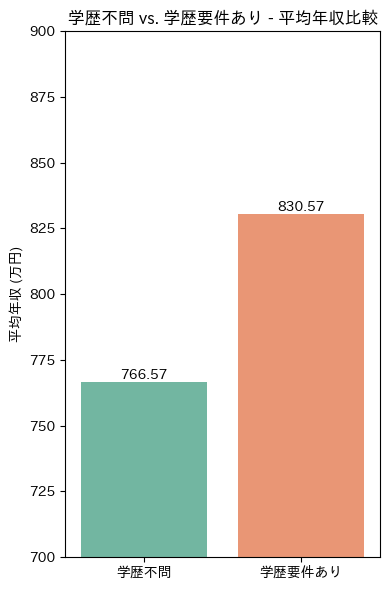

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

def main():
    # 1) データベースからデータを取得
    conn = sqlite3.connect("jobs.db")
    df_jobs = pd.read_sql_query("SELECT * FROM jobs", conn)
    conn.close()

    # 2) 前処理 (average_income が有効値である行のみを対象)
    df_filtered = df_jobs[
        (df_jobs["average_income"].notnull()) &  # 欠損がない
        (df_jobs["average_income"] > 0)          # 0 を超える
    ].copy()

    # is_academic_requirement_ok が None なら 0 (要件あり) に置き換える
    df_filtered["is_academic_requirement_ok"] = df_filtered["is_academic_requirement_ok"].fillna(0)

    # 3) 学歴不問・要件ありの平均年収を計算
    academic_ok_mean = df_filtered[df_filtered["is_academic_requirement_ok"] == 1]["average_income"].mean()
    academic_req_mean = df_filtered[df_filtered["is_academic_requirement_ok"] == 0]["average_income"].mean()

    # 可視化準備
    labels = ["学歴不問", "学歴要件あり"]
    values = [academic_ok_mean, academic_req_mean]

    # 4) グラフ描画
    plt.figure(figsize=(4, 6))
    sns.barplot(x=labels, y=values, palette="Set2")

    # 各棒の上に数値を描画
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.2f}", ha="center", fontweight='bold')

    # 必要に応じてY軸の最小・最大値を設定 (例として700～900)
    plt.ylim(700, 900)

    plt.title("学歴不問 vs. 学歴要件あり - 平均年収比較")
    plt.xlabel("")
    plt.ylabel("平均年収 (万円)")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

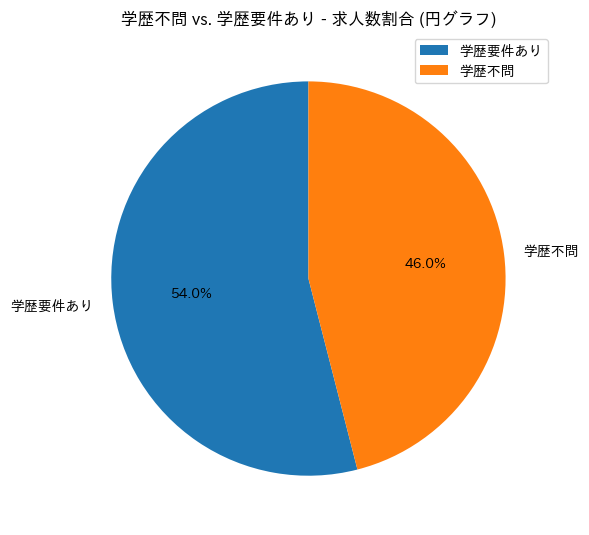

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# (必要に応じて) 日本語の文字化け回避用
# pip install japanize-matplotlib を行ったうえでコメントアウトを外してください
# import japanize_matplotlib

def main():
    # 1) jobs.db の jobs テーブルからデータを読み込み
    conn = sqlite3.connect("jobs.db")
    df_jobs = pd.read_sql_query("SELECT * FROM jobs", conn)
    conn.close()

    # 2) is_academic_requirement_ok カラム(数値)を文字ラベルにマッピング
    # 1 → "学歴不問", 0 → "学歴要件あり"
    df_jobs["academic_label"] = df_jobs["is_academic_requirement_ok"].map({
        1: "学歴不問",
        0: "学歴要件あり"
    })

    # 3) 円グラフ用に集計して描画
    count_series = df_jobs["academic_label"].value_counts()  # 求人数をカウント

    plt.figure(figsize=(6,6))
    count_series.plot(kind="pie", autopct="%1.1f%%", startangle=90)
    plt.title("学歴不問 vs. 学歴要件あり - 求人数割合 (円グラフ)")
    plt.ylabel("")  # 不要なy軸ラベルを消す
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [3]:
import pandas as pd
import sqlite3
from scipy import stats

def main():
    conn = sqlite3.connect("jobs.db")

    experienced_jobs_df = pd.read_sql_query("""
        SELECT average_income 
        FROM jobs
        WHERE is_inexperienced_ok = 0
    """, conn)

    inexperienced_jobs_df = pd.read_sql_query("""
        SELECT average_income 
        FROM jobs
        WHERE is_inexperienced_ok = 1
    """, conn)

    conn.close()

    # データのクリーニング (NaN が含まれている場合排除)
    experienced_salaries = experienced_jobs_df["average_income"].dropna().values
    inexperienced_salaries = inexperienced_jobs_df["average_income"].dropna().values

    # 要素数が十分ある場合のみ t-test
    if len(experienced_salaries) > 1 and len(inexperienced_salaries) > 1:
        # t-テストを実施
        t_statistic, p_value = stats.ttest_ind(experienced_salaries, inexperienced_salaries)

        print("【未経験者と経験者 t検定結果】")
        if p_value < 0.05:
            print("両者の平均に有意な差があります")
        else:
            print("両者の平均に有意な差がありません。")
    else:
        print("サンプル数が不足しているため、t検定を実行できません。")

if __name__ == "__main__":
    main()

【未経験者と経験者 t検定結果】
両者の平均に有意な差があります


In [ ]:
import pandas as pd
import sqlite3
from scipy import stats

def main():
    conn = sqlite3.connect("jobs.db")

    # 学歴不問データを抽出
    academic_ok_df = pd.read_sql_query("""
        SELECT average_income
        FROM jobs
        WHERE is_academic_requirement_ok = 1
    """, conn)

    # 学歴要件ありデータを抽出
    academic_req_df = pd.read_sql_query("""
        SELECT average_income
        FROM jobs
        WHERE is_academic_requirement_ok = 0
    """, conn)

    conn.close()

    # 欠損データを除去した配列を取り出す
    academic_ok_salaries = academic_ok_df["average_income"].dropna().values
    academic_req_salaries = academic_req_df["average_income"].dropna().values

    # もしサンプルが少ない場合は弾くなどの処理
    if len(academic_ok_salaries) > 1 and len(academic_req_salaries) > 1:
        # t検定(独立2標本)を実施
        t_statistic, p_value = stats.ttest_ind(academic_ok_salaries, academic_req_salaries)

        print("\n【学歴不問と学歴要件あり t検定結果】")

        if p_value < 0.05:
            print("両者の平均に有意な差があります。")
        else:
            print("両者の平均に有意な差がありません。")
    else:
        print("サンプル数が不足しています。t検定を実行できません。")

if __name__ == "__main__":
    main()


【学歴不問と学歴要件あり t検定結果】
両者の平均に有意な差があります。
